In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.stat import Correlation
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
# File location and type
file_location = "./lish-moa/train_features.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
features_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [ ]:
# File location and type
file_location = "./lish-moa/train_targets_scored.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
targets_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

### An interesting pattern in the gene expressions and cell viability values

In [4]:
features_df = features_data.toPandas()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


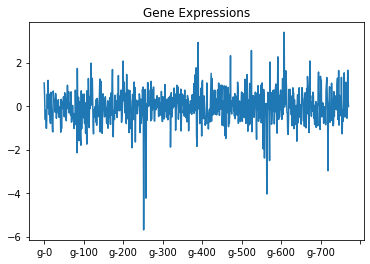

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


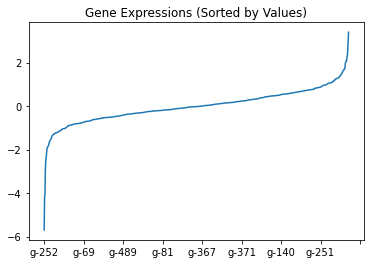

In [5]:
# Checking progression of gene_expressions values

# gene_expression values for 1st sample
features_df.iloc[0, 4:4+772].plot()
plt.title('Gene Expressions')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4:4+772].sort_values().plot()
plt.title('Gene Expressions (Sorted by Values)')
plt.show()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


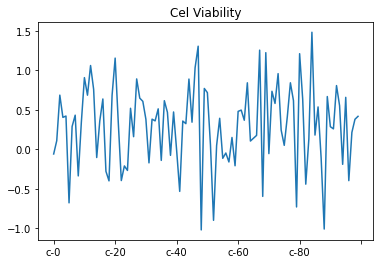

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


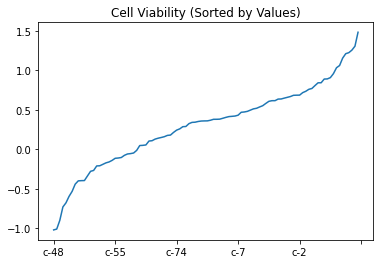

In [6]:
# Checking progression of cell viability values

# cell viability values for 1st sample
features_df.iloc[0, 4+772:].plot()
plt.title('Cel Viability')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4+772:].sort_values().plot()
plt.title('Cell Viability (Sorted by Values)')
plt.show()

As can be seen from the above graphs, gene expression and cell viability data (when sorted by values) might be interpreted as some time series data (same pattern exists for all samples). This info is further used in feature selection part, wherein max and min values of gene expression and cell viability are added as features for every sample 

### Pre-Processing

In [4]:
# Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 
features_and_targets = features_data.join(targets_data, features_data.sig_id == targets_data.sig_id, how='inner').drop(targets_data.sig_id)
features_and_targets = features_and_targets.filter("cp_type = 'trt_cp'")

In [5]:
# One hot encoding cp_dose

# Indexing different categories in cp_type and storing in column 'cp_type_index'
string_indexer = StringIndexer(inputCol = 'cp_dose', outputCol = 'cp_dose_index')
features_and_targets = string_indexer.fit(features_and_targets).transform(features_and_targets).drop('cp_dose')

# One hot encoded and stored in cp_type_vector column
encoder = OneHotEncoder(inputCols=['cp_dose_index'],
                        outputCols=['cp_dose'], dropLast = False)

features_and_targets = encoder.fit(features_and_targets).transform(features_and_targets).drop('cp_dose_index')

In [6]:
# Label Encoding cp_time
assembler = VectorAssembler(inputCols = ['cp_time'], outputCol = 'cp_time_vector')
features_and_targets = assembler.transform(features_and_targets).drop('cp_time')

mm_scaler = MinMaxScaler(inputCol = 'cp_time_vector', outputCol = 'cp_time_scaled_vector', min = 0, max = 2)
features_and_targets = mm_scaler.fit(features_and_targets).transform(features_and_targets).drop('cp_time_vector')

firstElement=udf(lambda v:float(v[0]),FloatType())
features_and_targets = features_and_targets.withColumn('cp_time', firstElement(features_and_targets['cp_time_scaled_vector'])).drop('cp_time_scaled_vector')

### Startified train-test split

In [7]:
'''
As our dataset is imbalanced, stratified train-test split was done so that test score is relevant. To perform stratified
split, I encoded all possible columns of target labels and then stratified was split was done based on the encoded value.
This ensures that, for every combination of target labels in the dataset, there are some samples both in train and test set
'''
# Encoding target labels' combination
def vector_to_string(a):
  s=''
  for i in a:
    s = s + str(i) + ' '
  s.strip()
  return s
    
  
vector_to_string = udf(vector_to_string)   
spark.udf.register("vector_to_string", vector_to_string)

# Target columns names
target_names = []
for feature in targets_data.columns:
  if feature != 'sig_id':
    target_names.append(feature)
    
temp_df = features_and_targets.withColumn('target_vector', (vector_to_string(array([features_and_targets[col] for col in target_names])))).select(['sig_id', 'target_vector'])
string_indexer = StringIndexer(inputCol = 'target_vector', outputCol = 'target')
string_indexer_model = string_indexer.fit(temp_df)
temp_df = string_indexer_model.transform(temp_df).drop('target_vector')

data = features_and_targets.join(temp_df, features_and_targets.sig_id == temp_df.sig_id, how = 'inner').drop(temp_df.sig_id)

unique_targets = data.select('target').distinct().collect()

# Train-test split (80-20 split)
fraction = {}
split_ratio = 0.2
for row in unique_targets:
  fraction[row.target] = split_ratio
  
test_data = data.sampleBy('target', fractions=fraction, seed = 0)
data.createOrReplaceTempView('data_table')
test_data.createOrReplaceTempView('test_data_table')
train_data = spark.sql('select * from data_table as t1 where t1.sig_id not in (select t2.sig_id from test_data_table as t2)') 

# Asserting no data leakage
train_data.createOrReplaceTempView('train_data_table')
count = spark.sql('select * from train_data_table as t1 where t1.sig_id in (select t2.sig_id from test_data_table as t2)').count()
assert count == 0

train_data = train_data.drop('target')
test_data = test_data.drop('target')

In [8]:
gene_feature_names = [] # list containing gene expression names
cell_feature_names = [] # list containing cell viability names

for i in range(772):
  gene_feature_names.append('g-' + str(i))

for i in range(100):
  cell_feature_names.append('c-' + str(i))

other_feature_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

target_names = [col for col in train_data.columns if col not in gene_feature_names + cell_feature_names + other_feature_names]

### Feature Engineering

In [ ]:
# Engineering new features: max and min values for gene expression and cell viability data

max_gene_train_df = train_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_train_df = train_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_train_df = train_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_train_df = train_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

max_gene_test_df = test_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_test_df = test_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_test_df = test_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_test_df = test_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

### Feature Selection

In [9]:
# Finding Correlation among cont. gene expression and cell viability data to remove all redundant features

# Correlation among gene expressions and cell viability

cont_features = gene_feature_names + cell_feature_names
cont_features_df = train_data.select(cont_features)

va = VectorAssembler(inputCols = cont_features, outputCol = 'features')
cont_features_df = va.transform(cont_features_df)

corr_df = Correlation.corr(cont_features_df, 'features', 'pearson').collect()[0][0]

corr_mat = corr_df.toArray()



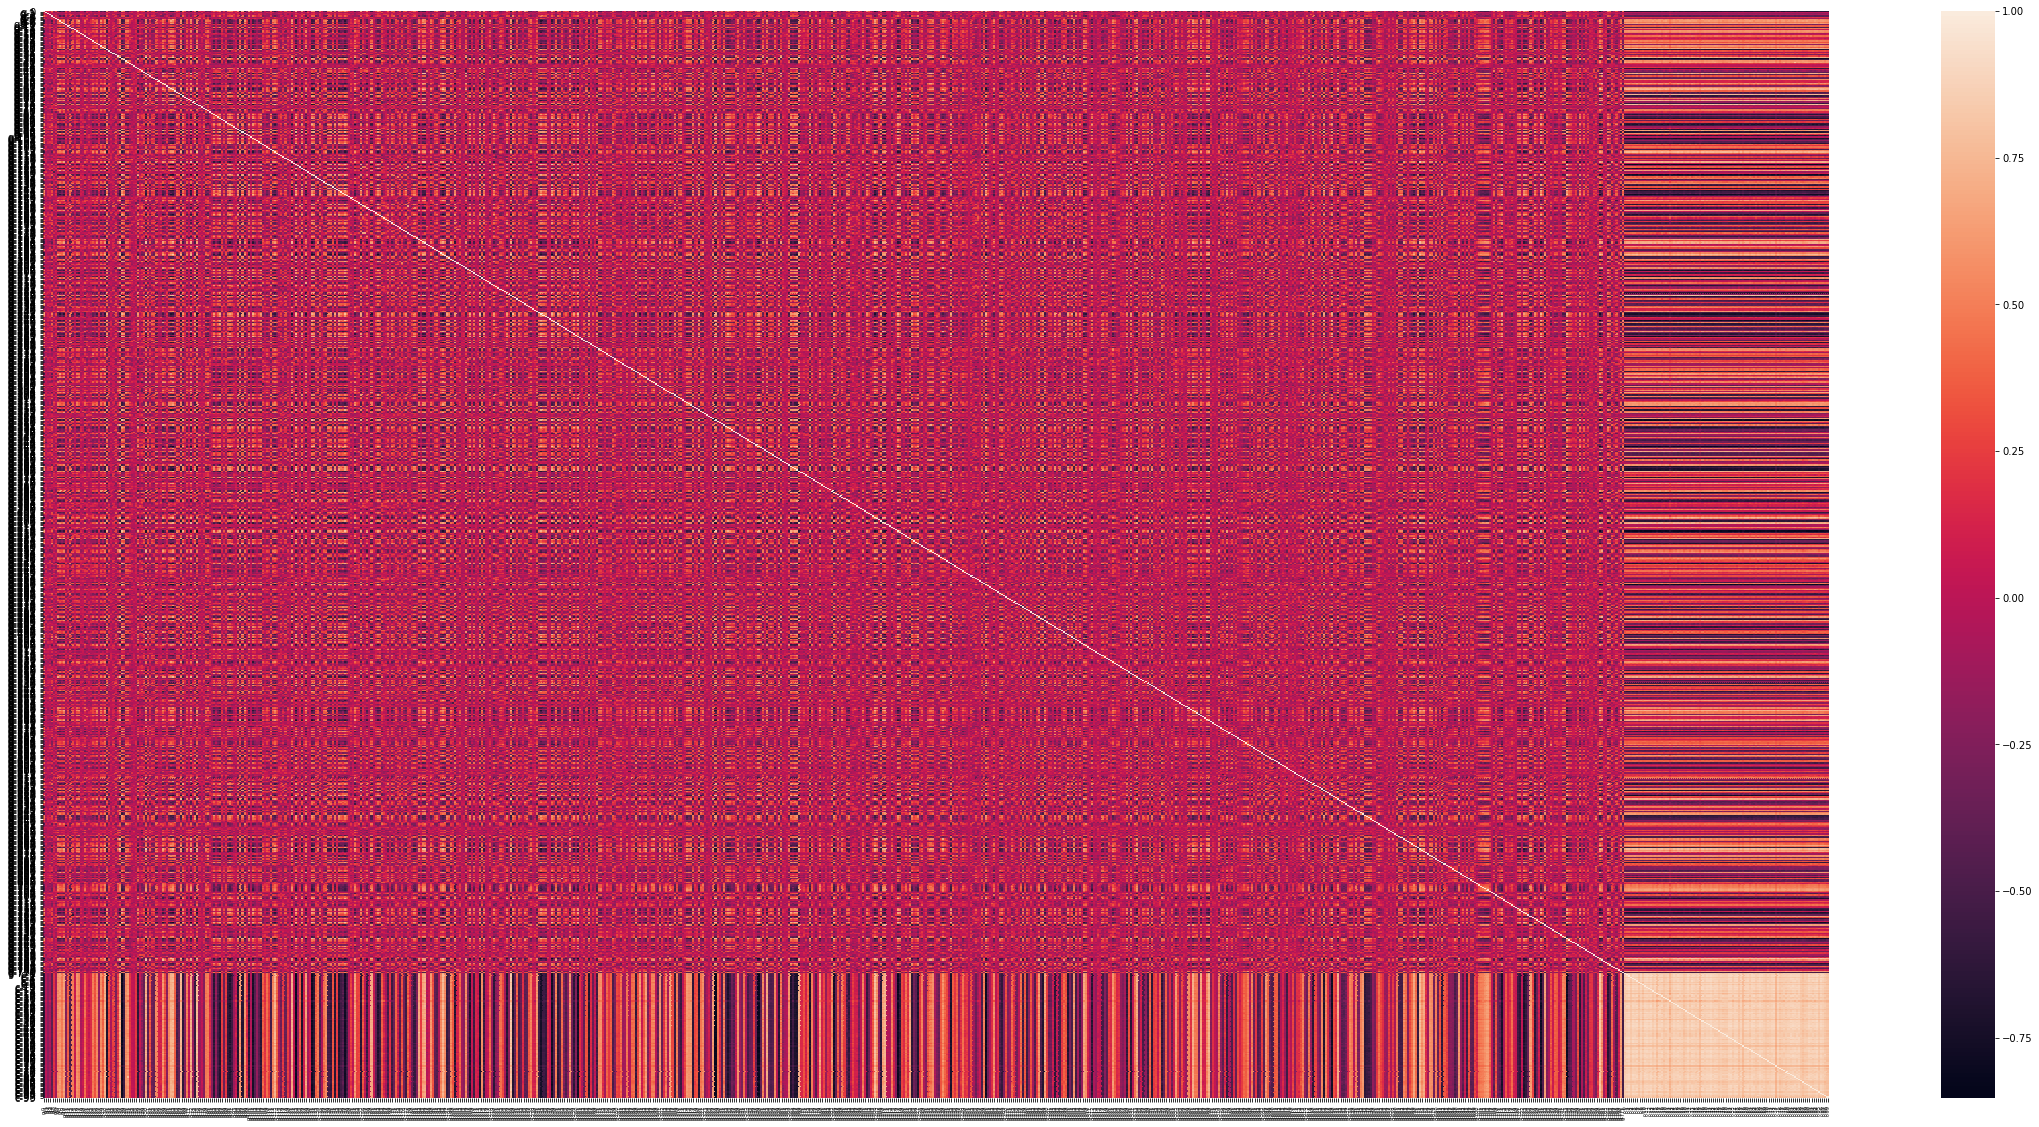

In [34]:
plt.figure(figsize=(40, 20))
sns.heatmap(corr_mat, xticklabels=gene_feature_names+cell_feature_names, yticklabels=gene_feature_names+cell_feature_names)
plt.xticks(rotation = 90, fontsize = 5)
plt.show()

In [ ]:
# Feature Selection: Removing highly correlated continuos features

threshold = 0.6
columns = np.full((corr_mat.shape[0], ), True, dtype = bool)
for i in range(corr_mat.shape[0]):
  for j in range(i+1, corr_mat.shape[0]):
    if not columns[j]:
      continue
    if corr_mat[i,j] >= threshold or corr_mat[i,j] <= -threshold :
      if columns[j]:
        columns[j] = False

selected_features = [(gene_feature_names + cell_feature_names)[i] for i, j in enumerate(columns) if j==True]

In [35]:
len(selected_features)

530

### Standardizing Selected Features

Adding engineered  features and then standardizing all continuous features

In [12]:
train_data = train_data.select(other_feature_names + selected_features + target_names).join(max_gene_train_df, on = 'sig_id', how = 'inner').join(min_gene_train_df, on = 'sig_id', how = 'inner').join(max_cell_train_df, on = 'sig_id', how = 'inner').join(min_cell_train_df, on = 'sig_id', how = 'inner')
test_data = test_data.select(other_feature_names + selected_features + target_names).join(max_gene_test_df, on = 'sig_id', how = 'inner').join(min_gene_test_df, on = 'sig_id', how = 'inner').join(max_cell_test_df, on = 'sig_id', how = 'inner').join(min_cell_test_df, on = 'sig_id', how = 'inner')

In [ ]:
selected_features = selected_features + ['gene_max', 'gene_min', 'cell_max', 'cell_min']

In [13]:
va = VectorAssembler(inputCols = selected_features, outputCol = 'feature_vector')

train_data = va.transform(train_data)
test_data = va.transform(test_data)

ss = StandardScaler(withMean=True, inputCol = 'feature_vector', outputCol='features')
ss_model = ss.fit(train_data)

train_data = ss_model.transform(train_data).drop('feature_vector')
test_data = ss_model.transform(test_data).drop('feature_vector')

### Dimensionality Reduction (PCA)

In [14]:
k = 100
pca = PCA(k = k, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(train_data)

In [36]:
cum_var = np.cumsum(pca_model.explainedVariance.toArray())

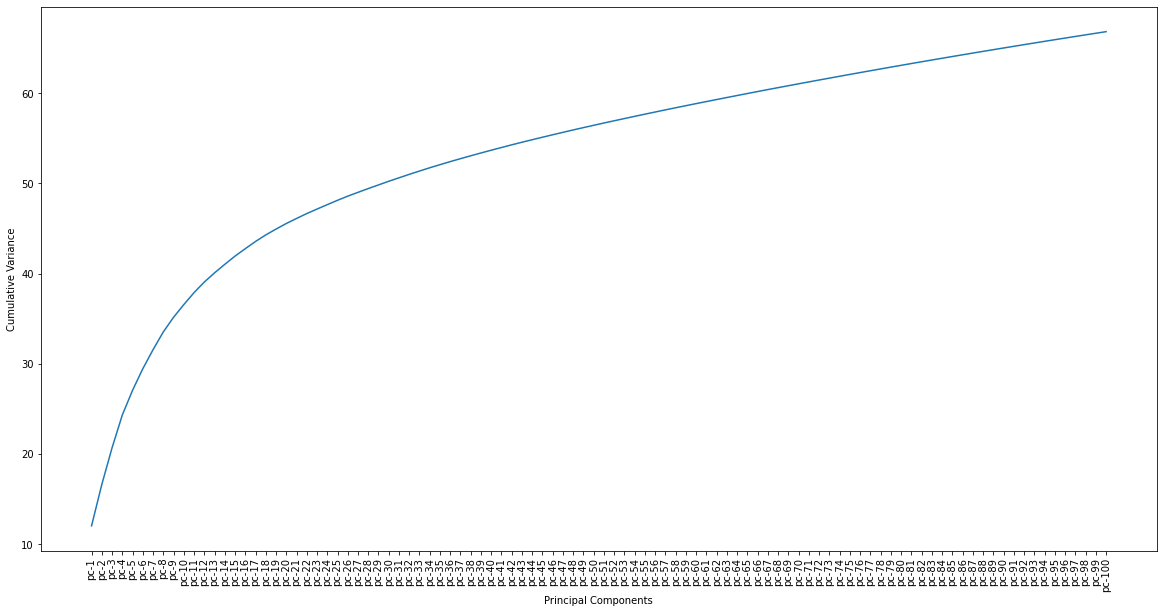

In [37]:
xlabels = ['pc-' + str(i+1) for i in range(k)]
plt.figure(figsize=(20,10))
plt.plot(xlabels, cum_var*100)
plt.xticks(rotation = 90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.show()

In [16]:
train_data = pca_model.transform(train_data).drop('features')
test_data = pca_model.transform(test_data).drop('features')

In [17]:
train_data = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)
test_data = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)

### Training and Testing

In [18]:
def logloss(predictedProb, trueLabel):
    loss = (-trueLabel*np.log(predictedProb + 10e-15) - (1-trueLabel)*(np.log(1-predictedProb))).mean()
    return loss

In [21]:
loss = 0
losses = [] # List to store log loss error for individual target labels
untrained_labels = [] # List to store target labels for which model was not trained

for i, label in enumerate(target_names):
  
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  one_count_train = X_train.filter(X_train[label] == 1).count()
  zero_count_train = X_train.filter(X_train[label] == 0).count()

#   If there are no activations for the label in the training dataset, no need to train the model (prediction would be all 0's)  
  if one_count_train == 0:
    untrained_labels.append(label)
    n = X_test.count()
    prob = np.array([0]*n)
    label = np.array(X_test.select(label).toPandas())[:,0]
    l = logloss(prob, label)
    print('No need to train the model. Will always output 0 for this label')
    
# Handling Data Imbalance: if number of samples with label 0 is more than twice the samples with label 1 - undersample
# majority class samples by half and oversample minority class samples so that counts are same 
    
  else:  
    factor = zero_count_train/one_count_train
    if factor>=2:
      zero_samples = X_train.filter(X_train[label]==0).sample(fraction = 0.5, withReplacement = False, seed = 0) 
      one_samples = spark.createDataFrame(X_train.filter(X_train[label]==1).toPandas().sample(n = int(X_train.filter(X_train[label]==0).count()/2), replace = True, random_state = 0))
      X_train = zero_samples.union(one_samples).orderBy(rand())
    va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
    X_train = va.transform(X_train)
    X_test = va.transform(X_test)

    logisticRegression = LogisticRegression(labelCol = label)
    print('Training Logistic Regression Model')
    logisticRegressionModel = logisticRegression.fit(X_train)
    print('Logistic Regression Trained')
    pred_df = logisticRegressionModel.transform(X_test)

    evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='logLoss')
    l= evaluator.evaluate(pred_df)
    
  losses.append(l)
  print(f'Label Loss for {i}: {label} = {l}')
  loss+=l
  print(f'Hamming Loss after {i}: {label} = {loss/(i+1)}')
  d = {'losses': losses, 'untrained_labels': untrained_labels }
  f = open('data.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')

  

Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.10303077270212385
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.10303077270212385
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.20346869311083826
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.15324973290648106
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 2: acat_inhibitor = 0.3316390896145197
Hamming Loss after 2: acat_inhibitor = 0.21271285180916064
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 3: acetylcholine_receptor_agonist = 0.5868273147818216
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.30624146755232584
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 4: acetylc

Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 37: atr_kinase_inhibitor = 0.10716485298694194
Hamming Loss after 37: atr_kinase_inhibitor = 0.2812896015348371
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 38: aurora_kinase_inhibitor = 0.17787910193136472
Hamming Loss after 38: aurora_kinase_inhibitor = 0.27863805026295324
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 39: autotaxin_inhibitor = 0.008243740433981099
Hamming Loss after 39: autotaxin_inhibitor = 0.27187819251722894
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 40: bacterial_30s_ribosomal_subunit_inhibitor = 0.4220624782846373
Hamming Loss after 40: bacterial_30s_ribosomal_subunit_inhibitor = 0.27554122387740965
################################
Training Logistic Regression Model
Logistic Regression Trai

Label Loss for 72: cytochrome_p450_inhibitor = 0.5168250618619991
Hamming Loss after 72: cytochrome_p450_inhibitor = 0.28486020575434423
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 73: dihydrofolate_reductase_inhibitor = 0.2495681269921651
Hamming Loss after 73: dihydrofolate_reductase_inhibitor = 0.2843832857710716
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 74: dipeptidyl_peptidase_inhibitor = 0.13958975934966836
Hamming Loss after 74: dipeptidyl_peptidase_inhibitor = 0.2824527054187862
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 75: diuretic = 0.014406457791417568
Hamming Loss after 75: diuretic = 0.2789257811078998
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 76: dna_alkylating_agent = 0.3357631577062036
Hamming Loss af

Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 108: hiv_inhibitor = 0.47927168689924876
Hamming Loss after 108: hiv_inhibitor = 0.2851913438075966
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 109: hmgcr_inhibitor = 0.13942267904118186
Hamming Loss after 109: hmgcr_inhibitor = 0.28386617412790194
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 110: hsp_inhibitor = 0.19555415499820297
Hamming Loss after 110: hsp_inhibitor = 0.2830705703519587
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 111: igf-1_inhibitor = 0.21548933260357941
Hamming Loss after 111: igf-1_inhibitor = 0.282467166443491
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 112: ikk_inhibitor = 0.08169957194463869
Hamming Loss after 112: ikk_i

Logistic Regression Trained
Label Loss for 144: opioid_receptor_antagonist = 0.5271527160697953
Hamming Loss after 144: opioid_receptor_antagonist = 0.2680189663760914
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 145: orexin_receptor_antagonist = 0.3554852764498088
Hamming Loss after 145: orexin_receptor_antagonist = 0.26861805069166483
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 146: p38_mapk_inhibitor = 0.17770731598637168
Hamming Loss after 146: p38_mapk_inhibitor = 0.26799961031952
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 147: p-glycoprotein_inhibitor = 0.1361118780687045
Hamming Loss after 147: p-glycoprotein_inhibitor = 0.267108476993501
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 148: parp_inhibitor = 0.3516389135

Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 180: sigma_receptor_antagonist = 0.307790679285671
Hamming Loss after 180: sigma_receptor_antagonist = 0.27207828232233505
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 181: smoothened_receptor_antagonist = 0.09563134784477978
Hamming Loss after 181: smoothened_receptor_antagonist = 0.2711087936713595
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 182: sodium_channel_inhibitor = 0.6161268377340883
Hamming Loss after 182: sodium_channel_inhibitor = 0.2729941381744345
################################
Training Logistic Regression Model
Logistic Regression Trained
Label Loss for 183: sphingosine_receptor_agonist = 0.125615084431121
Hamming Loss after 183: sphingosine_receptor_agonist = 0.2721931650562643
################################
Training Logistic Regression Model
Logistic Regres

In [22]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [23]:
len(data['losses'])

206

In [24]:
data['untrained_labels']

[]

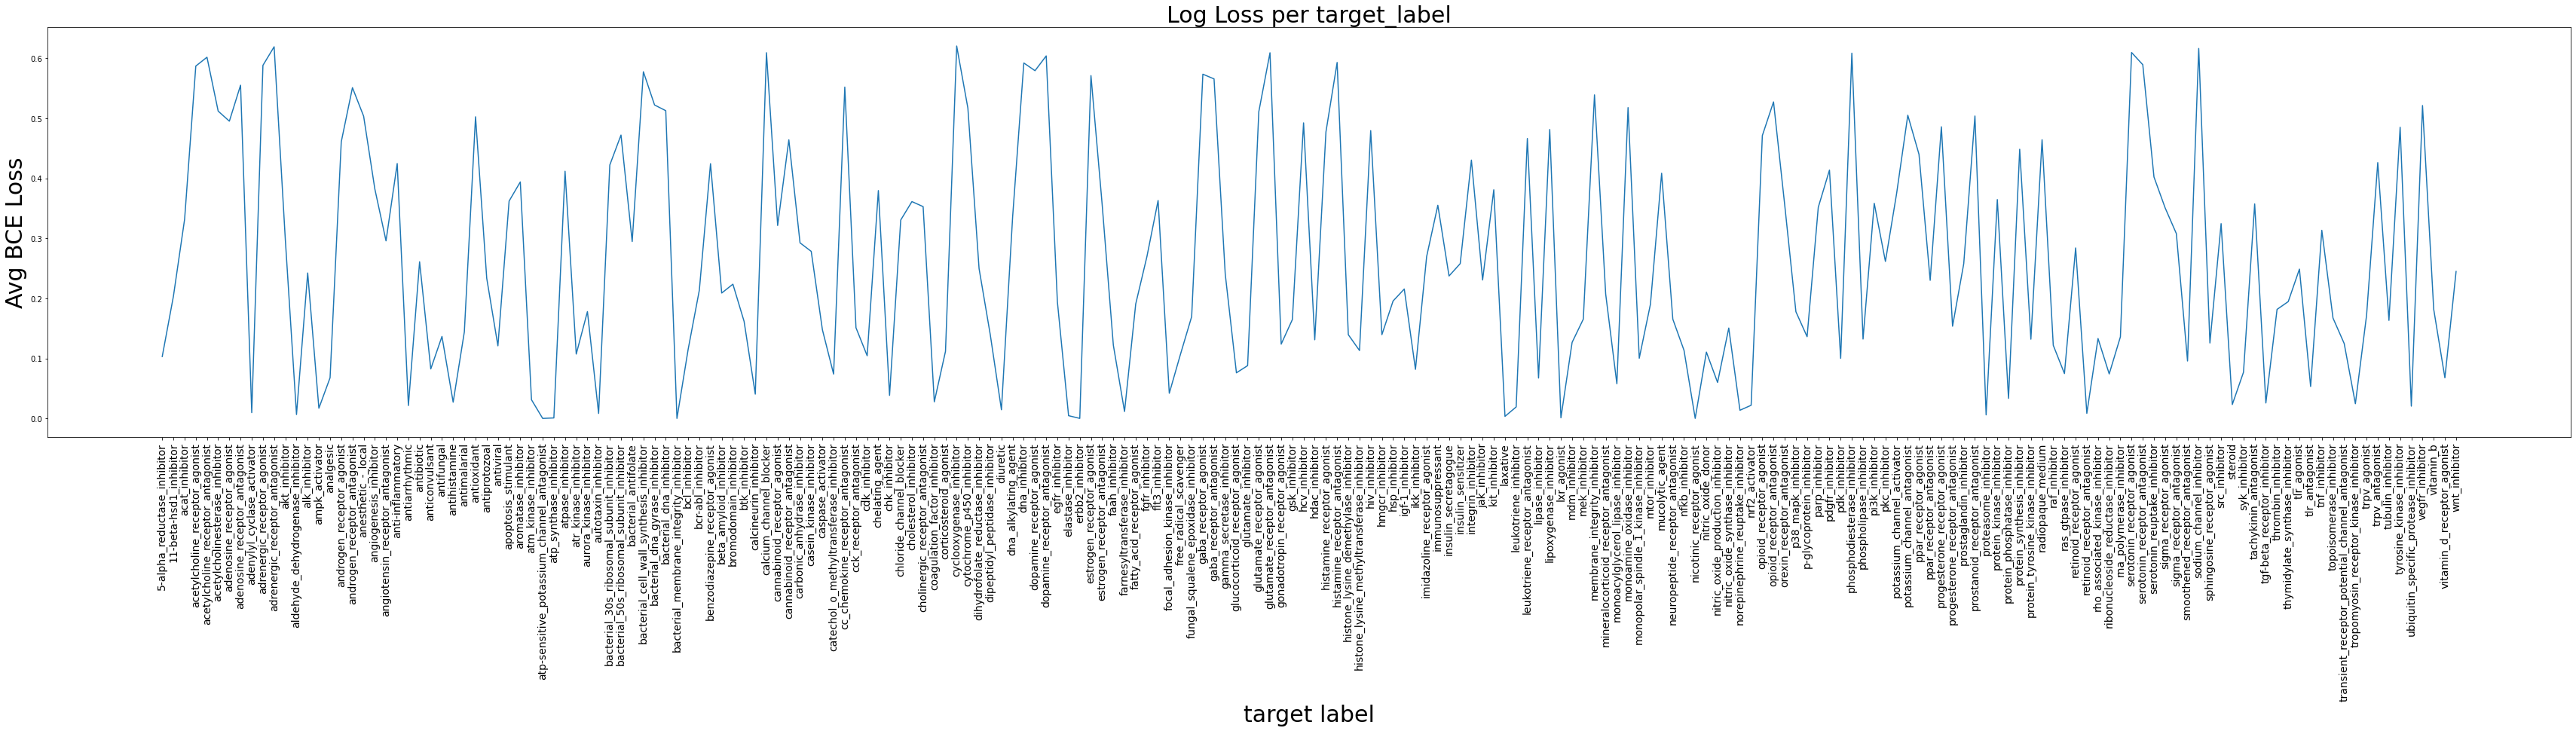

In [27]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['losses'])
plt.title('Log Loss per target_label', fontsize = 30)
plt.xlabel('target label', fontsize = 30)
plt.ylabel('Avg BCE Loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

In [30]:
def sum1(l):
    s = 0
    for i in l:
        s+=i
    return s

In [31]:
hamming_loss = [sum1(data['losses'][:i+1])/(i+1) for i in range(len(data['losses']))]

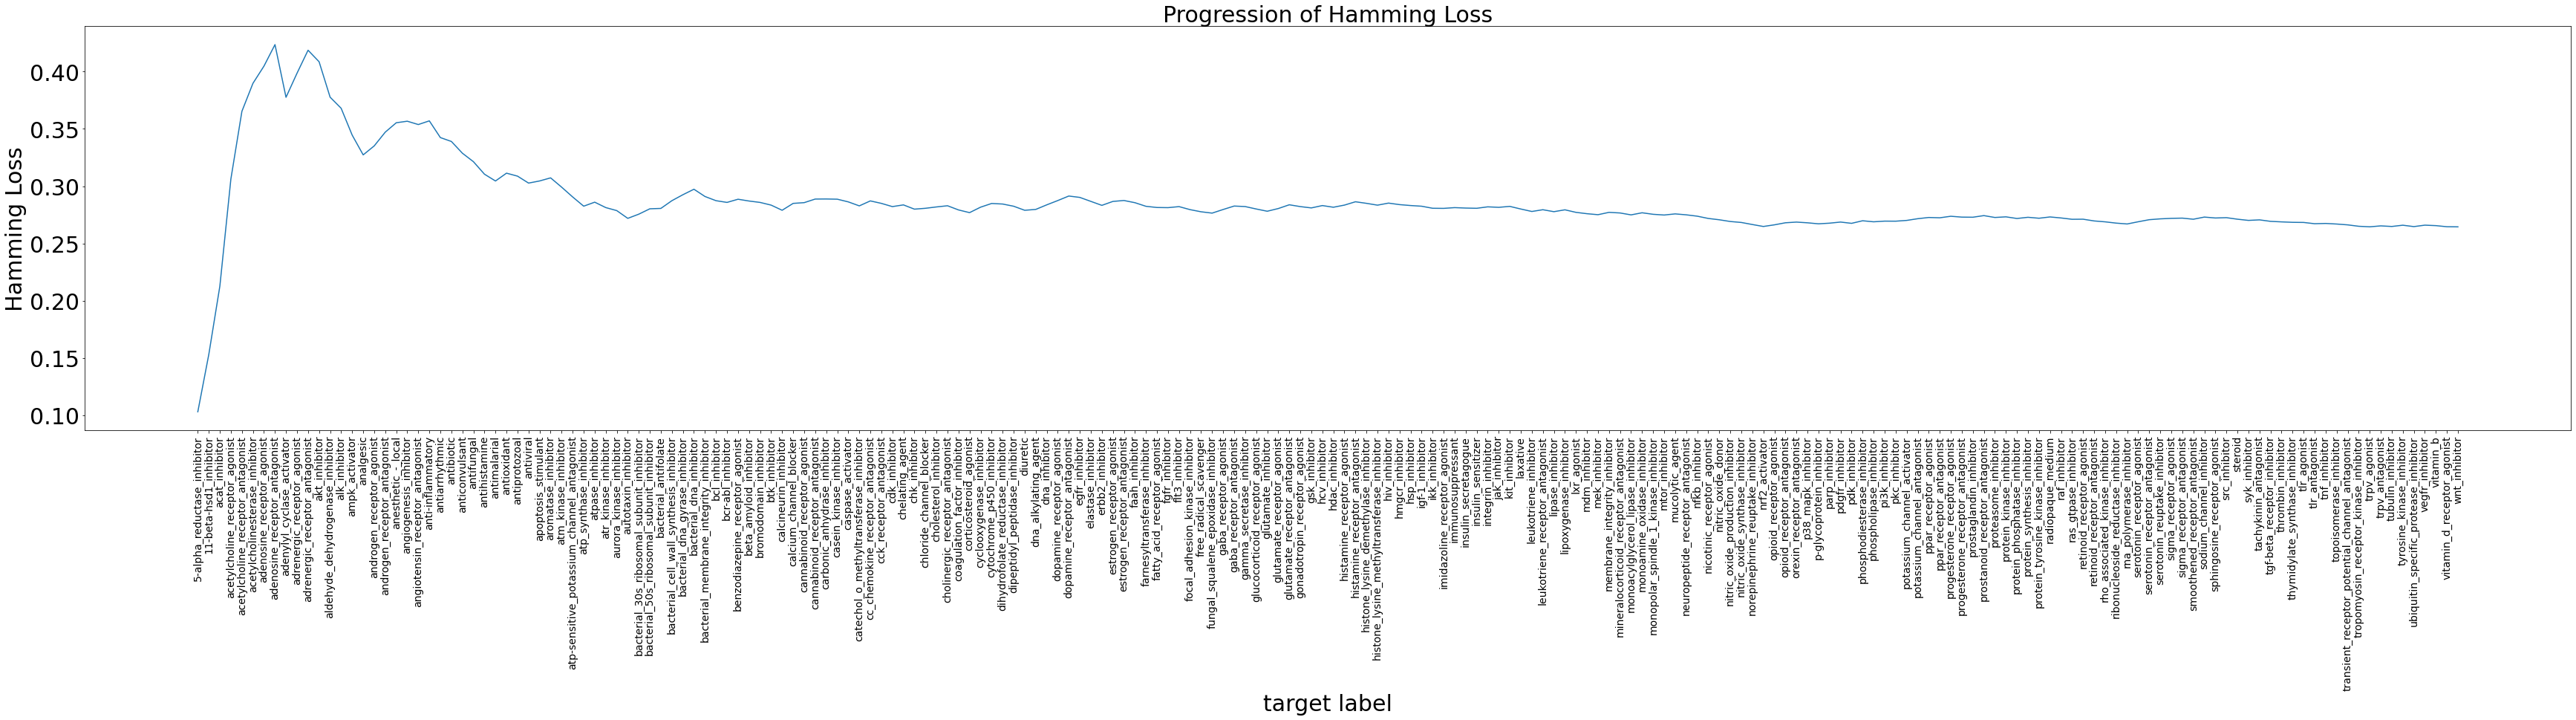

In [33]:
plt.figure(figsize = (60,10))
plt.plot(target_names, hamming_loss)
plt.title('Progression of Hamming Loss', fontsize = 30)
plt.xlabel('target label', fontsize = 30)
plt.ylabel('Hamming Loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 30)
plt.show()

In [ ]:
# Storing some info about training dynamics
data1 = data

In [39]:
data1['train_data'] = train_data.toPandas()
data1['test_data'] = test_data.toPandas()
data1['hamming_loss'] = hamming_loss
data1['variance'] = pca_model.explainedVariance.toArray()
data1['cumulative_variance'] = cum_var
data1['correlation_matrix'] = corr_mat
data1['selected_features'] = selected_features


In [40]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data1, f)